# Extract all fitted params from many dates in OGA butler

- Author : Sylvie Dagoret-Campagne
- creation date : 2024-01-14
- last update : 2024-01-14
- affiliation : IJCLab/IN2P3/CNRS


## Imports

In [1]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import pandas as pd
import matplotlib.gridspec as gridspec
from spectractor.tools import from_lambda_to_colormap, wavelength_to_rgb
#%matplotlib widget 
import h5py
from scipy import interpolate
from astropy.time import Time

In [2]:
import spectractor
from spectractor.simulation.throughput import load_transmission,plot_transmission_simple,TelescopeTransmission
from spectractor import parameters
from spectractor.extractor import dispersers
from spectractor.config import load_config,set_logger
import os,sys

In [3]:
plt.rcParams["figure.figsize"] = (8,8)
plt.rcParams["axes.labelsize"] = 'xx-large'
plt.rcParams['axes.titlesize'] = 'xx-large'
plt.rcParams['xtick.labelsize']= 'xx-large'
plt.rcParams['ytick.labelsize']= 'xx-large'
plt.rcParams['legend.fontsize']=  12
plt.rcParams['font.size'] = 12

In [4]:
import warnings
warnings.filterwarnings("ignore")

In [5]:
machine_name = os.uname().nodename
print(machine_name)
if 'sdf' in machine_name:
    #machine_name_usdf = 'sdfrome001'
    #machine_name_notebook platform = 'dagoret-nb'
    print("Set environement for USDF")
    newpythonpath = os.path.join(os.getenv("HOME"),"repos/repos_w_2023_44/rubinsimphot/src")
    sys.path.append(newpythonpath)
    newpythonpath = os.path.join(os.getenv("HOME"),"rubin-user/RubinLSSTPhotometricCorrTuto/notebooks/lib")
    sys.path.append(newpythonpath)   
elif "dagoret-nb" in machine_name:
    print("Set environement for Rubin Platform at  USDF")
    newpythonpath = os.path.join(os.getenv("HOME"),"repos/repos_w_2023_44/rubinsimphot/src")
    sys.path.append(newpythonpath)
    newpythonpath = os.path.join(os.getenv("HOME"),"rubin-user/RubinLSSTPhotometricCorrTuto/notebooks/lib")
    sys.path.append(newpythonpath)
elif 'mac' in machine_name:
    print("Be sure to run this notebook in conda environnement named conda_py310")
else:
    print("Your current machine name is {machine_name}. Check your python environment")

dagoret-nb
Set environement for Rubin Platform at  USDF


In [6]:
sys.path.append("../lib")
from libanaspectra import *

In [7]:
from rubinsimphot.phot_utils import Bandpass, Sed
from rubinsimphot.data.data_sets import  get_data_dir

#README.md        darksky.dat      filter_r.dat     hardware_g.dat   hardware_y.dat   lens3.dat        total_g.dat      total_y.dat
#README_SOURCE.md detector.dat     filter_u.dat     hardware_i.dat   hardware_z.dat   m1.dat           total_i.dat      total_z.dat
#atmos_10.dat     filter_g.dat     filter_y.dat     hardware_r.dat   lens1.dat        m2.dat           total_r.dat      version_info
#atmos_std.dat    filter_i.dat     filter_z.dat     hardware_u.dat   lens2.dat        m3.dat           total_u.dat
hardware_filenames = ["hardware_u.dat","hardware_g.dat","hardware_r.dat","hardware_i.dat","hardware_z.dat","hardware_y.dat"] 
filter_filenames = ["filter_u.dat","filter_g.dat","filter_r.dat","filter_i.dat","filter_z.dat","filter_y.dat" ]
total_filenames = ["total_u.dat","total_g.dat","total_r.dat","total_i.dat","total_z.dat","total_y.dat" ]
filter_tagnames = ["u","g","r","i","z","y"]
Filter_tagnames = ["U","G","R","I","Z","Y"]
filtercolor_tagnames = ["u-g","g-r","r-i","i-z","z-y"]
Filtercolor_tagnames = ["U-G","G-R","R-I","I-Y","Z-Y"]
filter_color = ["b","g","r","orange","grey","k"]
NFILT=len(filter_filenames)

WLMIN=300.
WLMAX=1100.
WLBIN=1.
NWLBIN=int((WLMAX-WLMIN)/WLBIN)
WL=np.linspace(WLMIN,WLMAX,NWLBIN)

In [8]:
#FILTERWL: precalculated array containing center, boundaries and width of each filter.
#index 0 : minimum wavelength of filter border
#index 1 : minimum wavelength of filter border
#index 2 : center wavelength of filter
#index 3 : filter width


FILTERWL = np.array([[ 324.03003755,  402.12765957,  363.59690349,   78.09762203],
       [ 392.11514393,  561.32665832,  473.54069923,  169.21151439],
       [ 542.3028786 ,  700.50062578,  619.49926767,  158.19774718],
       [ 681.47684606,  827.65957447,  752.01084117,  146.18272841],
       [ 808.63579474,  932.79098874,  868.488419  ,  124.15519399],
       [ 914.76846058, 1044.93116395,  969.10570859,  130.16270338]])

FILTERWL_auxtel = np.array([[ 352.7 ,  395.9 ,  374.3 ,   43.2 ],
                     [ 387.6 ,  566.2 ,  476.9 ,  178.6 ],
                     [ 541.4 ,  715.5 ,  628.45,  174.1 ],
                     [ 673.3 ,  870.9 ,  772.1 ,  197.6 ],
                     [ 805.6 , 1090.7 ,  948.15,  285.1 ]])


F0 = 3631.0 # Jy 1, Jy = 10^{-23} erg.cm^{-2}.s^{-1}.Hz^{-1}
Jy_to_ergcmm2sm1hzm1 = 1e-23
DT = 30.0 # seconds
gel = 1.1
#hP = 6.62607015E-34 # J⋅Hz−1
hP = 6.626196E-27
A  = np.pi*642.3**2 # cm2  Reff=6.423 m
A_auxtel  = 9636.0 # cm2

#ZPT_cont =  2.5 \log_{10} \left(\frac{F_0 A \Delta T}{g_{el} h} \right)
ZPTconst = 2.5*np.log10(F0*Jy_to_ergcmm2sm1hzm1*A*DT/gel/hP)

In [9]:
fdir = get_data_dir()
bandpass_inst = {}
path_rubin_sim_throughput = os.path.join(fdir, 'throughputs', 'baseline')
for index,filename in enumerate(hardware_filenames):
    fullfilename=os.path.join(path_rubin_sim_throughput,filename)
    arr= np.loadtxt(fullfilename)
    # interpolate  filter transmission
    ff = interpolate.interp1d(x=arr[:,0], y=arr[:,1],fill_value="extrapolate")
    fname = filter_tagnames[index]
    bandpass_inst[fname] = Bandpass(wavelen=WL,sb=ff(WL))

In [10]:
fig, axs = plt.subplots(1,1,figsize=(6,4))
# loop on filter
for index,f in enumerate(filter_tagnames):
    
    axs.plot(WL,bandpass_inst[f].sb,color=filter_color[index]) 
    axs.fill_between(WL,bandpass_inst[f].sb,color=filter_color[index],alpha=0.2) 
    axs.axvline(FILTERWL[index,2],color=filter_color[index],linestyle="-.")
    
axs.set_xlabel("$\\lambda$ (nm)")
axs.set_title("Total Rubin-LSST filter throughput")

Text(0.5, 1.0, 'Total Rubin-LSST filter throughput')

In [11]:
#from lsst.summit.utils.utils import checkStackSetup
#checkStackSetup()

In [12]:
import lsst.daf.butler as dafButler

repo = "/repo/main"
repo = "/repo/embargo"
# repo = "LATISS"
butler = dafButler.Butler(repo)
registry = butler.registry

for c in sorted(registry.queryCollections()):
    #if "u/jneveu" in c and "auxtel_atmo" in c:
    #if "u/dagoret" in c:
    if "u/dagoret" in c and "auxtel_atmo" in c:
        print(c)

u/dagoret/auxtel_atmo_202101_v3.0.3_doGainsPTC_rebin2_231208
u/dagoret/auxtel_atmo_202101_v3.0.3_doGainsPTC_rebin2_231208/20231220T142452Z
u/dagoret/auxtel_atmo_202209_v3.0.3_doGainsPTC_rebin2_231221
u/dagoret/auxtel_atmo_202209_v3.0.3_doGainsPTC_rebin2_231221/20231221T125249Z
u/dagoret/auxtel_atmo_202301_v3.0.3_doGainsNOPTC_rebin2_231208
u/dagoret/auxtel_atmo_202301_v3.0.3_doGainsNOPTC_rebin2_231208/20231208T215202Z
u/dagoret/auxtel_atmo_202301_v3.0.3_doGainsPTC_rebin2_231208
u/dagoret/auxtel_atmo_202301_v3.0.3_doGainsPTC_rebin2_231208/20231208T211104Z
u/dagoret/auxtel_atmosphere_202301_v3.0.3_doGainsPTC_rebin2
u/dagoret/auxtel_atmosphere_202301_v3.0.3_doGainsPTC_rebin2/20231208T100936Z
u/dagoret/auxtel_atmosphere_202301_v3.0.3_doGainsPTC_rebin2/20231208T130352Z


## Config

### Config collection

In [13]:
#my_collection = "u/dagoret/auxtel_atmo_202301_v3.0.3_doGainsPTC_rebin2_231208"
#my_collection = "u/dagoret/auxtel_atmo_202301_v3.0.3_doGainsNOPTC_rebin2_231208"

# all spectra from September 2022 to december 2023
#the reconstruction done by  LambdaMin = 350.0 and spectractor v3.0.3 in 2023/12/21

my_collection = "u/dagoret/auxtel_atmo_202209_v3.0.3_doGainsPTC_rebin2_231221"
#my_collection = "u/dagoret/auxtel_atmo_202301_v3.0.3_doGainsNOPTC_rebin2_231208"

### Config Auxtel

In [14]:
#config_path = "~/repos/repos_w_2023_44/Spectractor/config/auxtel.ini"
#config_path = "/home/d/dagoret/repos/repos_w_2023_44/Spectractor/config/auxtel.ini"
config_fullpath = os.path.join(spectractor.__path__[0],"../config/auxtel.ini")
throughput_filename="multispectra_holo4_003_HD142331_20230802_AuxTel_doGainsPTC_v3.0.3_throughput.txt"

In [15]:
load_config(config_fullpath)

### Config Telescope Throughtput

In [16]:
throughput_fullpath = os.path.join(spectractor.__path__[0],parameters.THROUGHPUT_DIR)
throughput_fullfilename = os.path.join(throughput_fullpath,throughput_filename)

In [17]:
tel_lambdas, tel_thr, tel_errthr = load_transmission(throughput_fullfilename) 

In [18]:
parameters.THROUGHPUT_DIR = throughput_fullpath 
parameters.OBS_FULL_INSTRUMENT_TRANSMISSON = throughput_filename
print(parameters.THROUGHPUT_DIR )
print(parameters.OBS_FULL_INSTRUMENT_TRANSMISSON)

/home/d/dagoret/repos/repos_w_2023_44/Spectractor/lib/python/spectractor/simulation/AuxTelThroughput/
multispectra_holo4_003_HD142331_20230802_AuxTel_doGainsPTC_v3.0.3_throughput.txt


In [19]:
%matplotlib inline
tel = TelescopeTransmission()
tel.plot_transmission()

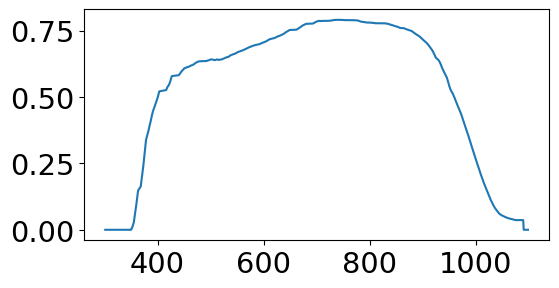

In [20]:
%matplotlib inline
fig = plt.figure(figsize=(6,3))
ax = fig.add_subplot()
ax.plot(tel_lambdas,tel.transmission(tel_lambdas))

### Config disperser

In [21]:
disp = dispersers.Hologram("holo4_003")

## Load config filename for Auxtel

In [22]:
load_config(config_fullpath)

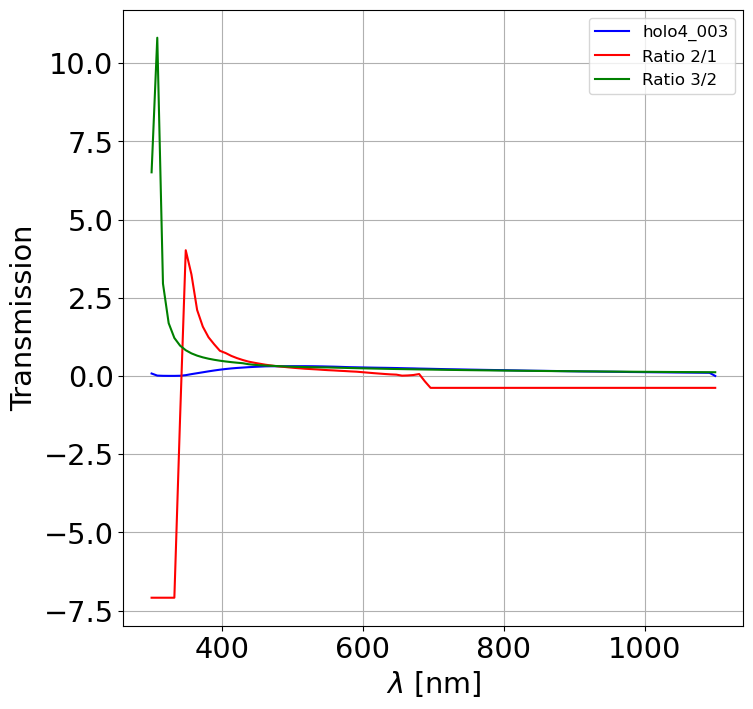

In [23]:
disp.plot_transmission()

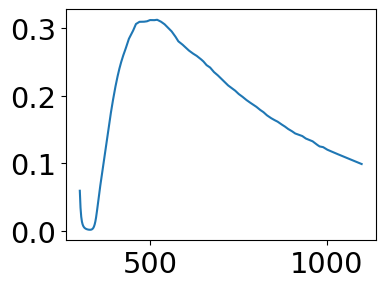

In [24]:
fig = plt.figure(figsize=(4,3))
ax = fig.add_subplot()
ax.plot(tel_lambdas,disp.transmission(tel_lambdas))

## Check the presence of the spectra

### select the date of observation in 2023

In [25]:
ALL_DATEOBS = np.array([20230117, 20230118, 20230119, 20230131, 20230201, 20230202,
       20230214, 20230215, 20230216, 20230228, 20230301, 20230302,
       20230314, 20230315, 20230316, 20230509, 20230510, 20230511,
       20230523, 20230524, 20230525, 20230718, 20230720, 20230801,
       20230802, 20230815, 20230817, 20230829, 20230912, 20230913,
       20230914, 20230926, 20230927, 20230928, 20231010, 20231107,
       20231108, 20231113, 20231114, 20231115, 20231116, 20231120,
       20231127, 20231128, 20231129, 20231130, 20231204, 20231205,
       20231206, 20231207, 20231211, 20231212, 20231214, 20231215,
       20231219, 20231220])

file_out_allfittedparams = "out_allfittedparams.csv"

- Split in 4 parts because too many files open

In [26]:
#ALL_DATEOBS = np.array([20230117, 20230118, 20230119, 20230131, 20230201, 20230202,
#       20230214, 20230215, 20230216, 20230228, 20230301, 20230302,
#       20230314, 20230315, 20230316]) 
#file_out_allfittedparams = "out_allfittedparams_1_4.csv"
                        
#ALL_DATEOBS = np.array([20230509, 20230510, 20230511,
#       20230523, 20230524, 20230525, 20230718, 20230720, 20230801,
#       20230802, 20230815, 20230817, 20230829]) 
#file_out_allfittedparams = "out_allfittedparams_2_4.csv"                        
                        
#ALL_DATEOBS = np.array([20230912, 20230913,
#       20230914, 20230926, 20230927, 20230928, 20231010, 20231107,
#       20231108, 20231113, 20231114, 20231115, 20231116]) 
#file_out_allfittedparams = "out_allfittedparams_3_4.csv"


ALL_DATEOBS = np.array([20231120,
       20231127, 20231128, 20231129, 20231130, 20231204, 20231205,
       20231206, 20231207, 20231211, 20231212, 20231214, 20231215,
       20231219, 20231220])
file_out_allfittedparams = "out_allfittedparams_4_4.csv"

In [27]:
len(ALL_DATEOBS)

15

## Access to spectra using the butler

In [28]:
all_records = []
for DATEOBS in ALL_DATEOBS:
    where = f"instrument='LATISS' and visit.day_obs={DATEOBS}" 
    records = list(butler.registry.queryDimensionRecords('visit', datasets='spectractorSpectrum', where=where,  collections=my_collection))
    all_records.append(records)
    print(f">>> {DATEOBS} :  Number of records : ",len(records))
    

>>> 20231120 :  Number of records :  46
>>> 20231127 :  Number of records :  36
>>> 20231128 :  Number of records :  33
>>> 20231129 :  Number of records :  32
>>> 20231130 :  Number of records :  30
>>> 20231204 :  Number of records :  41
>>> 20231205 :  Number of records :  26
>>> 20231206 :  Number of records :  19
>>> 20231207 :  Number of records :  20
>>> 20231211 :  Number of records :  36
>>> 20231212 :  Number of records :  21
>>> 20231214 :  Number of records :  40
>>> 20231215 :  Number of records :  19
>>> 20231219 :  Number of records :  21
>>> 20231220 :  Number of records :  34


In [29]:
len(all_records)

15

## Get params, times, headers and Spectra

In [30]:
all_params_spectrum = []
all_params_spectrogram = []
all_times = []
all_headers = []
#all_spectra = []

for idx,DATEOBS in enumerate(ALL_DATEOBS):
    print(idx,DATEOBS)
    records = all_records[idx]


    params_spectrum = []
    params_spectrogram = []
    times = []
    headers = []
    spectra = []

    for i, r in enumerate(records):
        try:
            times.append(r.day_obs)
            spec =  butler.get('spectractorSpectrum', visit=r.id, collections=my_collection, detector=0, instrument='LATISS')
            headers.append(spec.header)
            spectra.append(spec)
            p = butler.get('spectrumLibradtranFitParameters', visit=r.id, collections=my_collection, detector=0, instrument='LATISS')
            params_spectrum.append(p)
            p = butler.get('spectrogramLibradtranFitParameters', visit=r.id, collections=my_collection, detector=0, instrument='LATISS')
            params_spectrogram.append(p)
    #except ValueError:
        except Exception as inst:
            except_type = type(inst)
            except_args = inst.args
            print("catch exception ", inst, "type =",except_type, "args = ",except_args) 
            print("\t >>>>> Skip record ", r.id)
            continue

    all_params_spectrum.append(params_spectrum)
    all_params_spectrogram.append(params_spectrogram)
    all_times.append(times)
    all_headers.append(headers)
    #all_spectra.append(spectra)

0 20231120
************ getObsAtmo imported ************* 
/home/d/dagoret/.local/lib/python3.11/site-packages/getObsAtmo
>>>> _getPackageDir /home/d/dagoret/.local/lib/python3.11/site-packages/getObsAtmo
>>>> getObsSiteDataFrame      altitude   pressure
LSST    2.663  731.50433
CTIO    2.207   774.6052
OHP      0.65  937.22595
PDM    2.8905  710.90637
OMK     4.205  600.17224
OSL       0.0     1013.0


2024-01-15 14:55:54  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-15 14:55:54  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-15 14:55:55  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-15 14:55:55  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-15 14:55:55  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-15 14:55:56  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-15 14:55:56  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-15 14:55:56  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-15 14:55:57  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-15 14:55:57  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-15 14:55:57  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-15 14:55:58  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-15 14:55:58  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-15 14:55:59  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-15 14:55:59  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-15 14:55:59  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-15 14:56:00  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-15 14:56:00  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-15 14:56:00  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-15 14:56:01  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-15 14:56:01  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-15 14:56:01  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-15 14:56:02  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-15 14:56:02  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-15 14:56:02  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-15 14:56:03  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-15 14:56:03  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-15 14:56:04  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-15 14:56:04  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-15 14:56:04  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-15 14:56:05  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-15 14:56:05  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-15 14:56:05  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-15 14:56:06  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-15 14:56:06  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-15 14:56:06  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-15 14:56:07  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-15 14:56:07  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-15 14:56:07  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-15 14:56:08  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-15 14:56:08  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-15 14:56:08  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-15 14:56:09  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-15 14:56:09  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-15 14:56:10  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-15 14:56:10  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


1 20231127


2024-01-15 14:56:11  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-15 14:56:11  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-15 14:56:11  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-15 14:56:12  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-15 14:56:12  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-15 14:56:12  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-15 14:56:13  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-15 14:56:13  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-15 14:56:13  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-15 14:56:14  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-15 14:56:14  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-15 14:56:15  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-15 14:56:15  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-15 14:56:16  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-15 14:56:16  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-15 14:56:17  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-15 14:56:17  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-15 14:56:17  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-15 14:56:18  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-15 14:56:18  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-15 14:56:18  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-15 14:56:19  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-15 14:56:19  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-15 14:56:19  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-15 14:56:20  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-15 14:56:20  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-15 14:56:20  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-15 14:56:21  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-15 14:56:21  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-15 14:56:21  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-15 14:56:22  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-15 14:56:22  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-15 14:56:22  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-15 14:56:23  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-15 14:56:24  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-15 14:56:24  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2 20231128
3 20231129
4 20231130
5 20231204
6 20231205
7 20231206
8 20231207
9 20231211
10 20231212
11 20231214
12 20231215
13 20231219
14 20231220


## Filtering data

In [31]:
all_filtered_spectra = []

for idx,DATEOBS in enumerate(ALL_DATEOBS):
    records = all_records[idx]
    spectra_filtered = filter_data(butler,my_collection,DATEOBS,records)
    all_filtered_spectra.append(spectra_filtered)
    

2024-01-15 14:58:42  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-15 14:58:42  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-15 14:58:43  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-15 14:58:43  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-15 14:58:43  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-15 14:58:43  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-15 14:58:43  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-15 14:58:44  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-15 14:58:44  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-15 14:58:44  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-15 14:58:44  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-15 14:58:44  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-15 14:58:45  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-15 14:58:45  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-15 14:58:45  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-15 14:58:45  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-15 14:58:46  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-15 14:58:46  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-15 14:58:46  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-15 14:58:46  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-15 14:58:46  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-15 14:58:47  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-15 14:58:47  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-15 14:58:47  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-15 14:58:47  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-15 14:58:48  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-15 14:58:48  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-15 14:58:48  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-15 14:58:48  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-15 14:58:49  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-15 14:58:49  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-15 14:58:49  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-15 14:58:50  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-15 14:58:50  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-15 14:58:50  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-15 14:58:50  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-15 14:58:51  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-15 14:58:51  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-15 14:58:51  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-15 14:58:51  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-15 14:58:52  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-15 14:58:52  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-15 14:58:52  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-15 14:58:52  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-15 14:58:53  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-15 14:58:53  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-15 14:58:53  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-15 14:58:53  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-15 14:58:53  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-15 14:58:54  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-15 14:58:54  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-15 14:58:54  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-15 14:58:54  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-15 14:58:55  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-15 14:58:55  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-15 14:58:55  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-15 14:58:55  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-15 14:58:55  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-15 14:58:56  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-15 14:58:56  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-15 14:58:56  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-15 14:58:56  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-15 14:58:57  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-15 14:58:57  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-15 14:58:57  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-15 14:58:58  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-15 14:58:58  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-15 14:58:58  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-15 14:58:58  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-15 14:58:59  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-15 14:58:59  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-15 14:58:59  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-15 14:58:59  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-15 14:59:00  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-15 14:59:00  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-15 14:59:00  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-15 14:59:00  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-15 14:59:01  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-15 14:59:01  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-15 14:59:01  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-15 14:59:01  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2024-01-15 14:59:02  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


## Information from atmospheric fits

In [32]:
headers = all_headers[0]

In [33]:
columns_spectrum = ["id"]

for h in headers[0]:
    if "COMMENT" in h or "EXTNAME" in h: continue
    if "LBDAS_T" in h or "PSF_P_T" in h or "AMPLIS_T" in h: continue
    if "UNIT" in h: continue
    if "SIMPLE" in h: continue
    columns_spectrum.append(h)
 
columns_spectrogram_bestfit = []
for key in params_spectrogram[0].labels:
    columns_spectrogram_bestfit.append(key)
    columns_spectrogram_bestfit.append(key+"_err")

columns_spectrum_bestfit = []
for key in params_spectrum[0].labels:
    columns_spectrum_bestfit.append(key)
    columns_spectrum_bestfit.append(key+"_err")

In [34]:
print(columns_spectrum)

['id', 'BITPIX', 'NAXIS', 'NAXIS1', 'NAXIS2', 'EXTEND', 'TARGET', 'REDSHIFT', 'GRATING', 'ROTANGLE', 'D2CCD', 'LSHIFT', 'PARANGLE', 'TARGETX', 'TARGETY', 'LBDA_REF', 'PSF_REG', 'TRACE_R', 'MEANFWHM', 'PIXSHIFT', 'CHI2_FIT', 'A2_FIT', 'AM_FIT', 'VERSION', 'REBIN', 'CONFIG', 'DATE-OBS', 'EXPTIME', 'AIRMASS', 'DEC', 'HA', 'OUTTEMP', 'OUTPRESS', 'OUTHUM', 'FILTER', 'CAM_ROT', 'S_X0', 'S_Y0', 'S_XMIN', 'S_XMAX', 'S_YMIN', 'S_YMAX', 'S_NX', 'S_NY', 'S_DEG', 'S_SAT', 'S_ORDER']


In [35]:
print(columns_spectrogram_bestfit)

['A1', 'A1_err', 'A2', 'A2_err', 'A3', 'A3_err', 'VAOD', 'VAOD_err', 'angstrom_exp', 'angstrom_exp_err', 'ozone [db]', 'ozone [db]_err', 'PWV [mm]', 'PWV [mm]_err', 'D_CCD [mm]', 'D_CCD [mm]_err', 'shift_x [pix]', 'shift_x [pix]_err', 'shift_y [pix]', 'shift_y [pix]_err', 'angle [deg]', 'angle [deg]_err', 'B', 'B_err', 'x_c_0_1', 'x_c_0_1_err', 'x_c_1_1', 'x_c_1_1_err', 'x_c_2_1', 'x_c_2_1_err', 'y_c_0_1', 'y_c_0_1_err', 'y_c_1_1', 'y_c_1_1_err', 'y_c_2_1', 'y_c_2_1_err', 'gamma_0_1', 'gamma_0_1_err', 'gamma_1_1', 'gamma_1_1_err', 'gamma_2_1', 'gamma_2_1_err', 'alpha_0_1', 'alpha_0_1_err', 'alpha_1_1', 'alpha_1_1_err', 'alpha_2_1', 'alpha_2_1_err', 'saturation_0_1', 'saturation_0_1_err', 'x_c_0_2', 'x_c_0_2_err', 'x_c_1_2', 'x_c_1_2_err', 'x_c_2_2', 'x_c_2_2_err', 'y_c_0_2', 'y_c_0_2_err', 'y_c_1_2', 'y_c_1_2_err', 'y_c_2_2', 'y_c_2_2_err', 'gamma_0_2', 'gamma_0_2_err', 'gamma_1_2', 'gamma_1_2_err', 'gamma_2_2', 'gamma_2_2_err', 'alpha_0_2', 'alpha_0_2_err', 'alpha_1_2', 'alpha_1_2_err

In [36]:
print(columns_spectrum_bestfit)

['A1', 'A1_err', 'A2', 'A2_err', 'VAOD', 'VAOD_err', 'angstrom_exp', 'angstrom_exp_err', 'ozone [db]', 'ozone [db]_err', 'PWV [mm]', 'PWV [mm]_err', 'reso [pix]', 'reso [pix]_err', 'D_CCD [mm]', 'D_CCD [mm]_err', 'alpha_pix [pix]', 'alpha_pix [pix]_err', 'B', 'B_err']


## Merge dataframes of general paramters and fitted params

In [37]:
all_df = []

for idx,DATEOBS in enumerate(ALL_DATEOBS):
  
    records = all_records[idx]
    headers = all_headers[idx]
    params_spectrogram = all_params_spectrogram[idx]
    params_spectrum = all_params_spectrum[idx]
   
    min_index = 0
    max_index = np.inf

    # General parameters
    df1 = pd.DataFrame(columns=columns_spectrum)
    for k, header in enumerate(headers):
        # if k > 40: break
        n = records[k].id
        if n < min_index or n > max_index: continue
        row = {"id": n}
        for h in header:
            if h in columns_spectrum:
                row[h] = header[h]
        df1.loc[len(df1)] = row


    # fitted parameters in Spectrogram
    df2 = pd.DataFrame(columns=columns_spectrogram_bestfit)
    for k, p in enumerate(params_spectrogram):
        n = records[k].id
        if n < min_index or n > max_index: continue
        row = {"id": n}
        for i, key in enumerate(p.labels):
            row[key] = p.values[i]
            row[key+"_err"] = p.err[i]
        df2.loc[len(df2)] = row

    # fitted parameters in Spectrum
    df3 = pd.DataFrame(columns=columns_spectrum_bestfit)
    for k, p in enumerate(params_spectrum):
        n = records[k].id
        if n < min_index or n > max_index: continue
        row = {"id": n}
        for i, key in enumerate(p.labels):
            row[key] = p.values[i]
            row[key+"_err"] = p.err[i]
        df3.loc[len(df3)] = row

    df = pd.merge(df1, df2, left_index=True, right_index=True)
    df = pd.merge(df, df3, left_index=True, right_index=True)
    df.set_index('DATE-OBS', inplace=True)
    #df.index = pd.to_datetime(df.index, format="ISO8601") #['DATE-OBS'])
    df.index = pd.to_datetime(df.index) #['DATE-OBS'])
    df.sort_index(inplace=True)

    all_df.append(df)
            

In [38]:
all_df[0].head()

,id,BITPIX,NAXIS,NAXIS1,NAXIS2,EXTEND,TARGET,REDSHIFT,GRATING,ROTANGLE,...,PWV [mm]_y,PWV [mm]_err_y,reso [pix],reso [pix]_err,D_CCD [mm]_y,D_CCD [mm]_err_y,alpha_pix [pix],alpha_pix [pix]_err,B_y,B_err_y
DATE-OBS,,,,,,,,,,,,,,,,,,,,,
2023-11-21 01:37:13.904502514+00:00,2023112000082,-64,2,1067,3,True,HD2811,0.000000,holo4_003,0.179791,...,2.698822,0.044086,2.663446,0.036957,186.994145,0.008052,0.898345,0.0,0.0,0.0
2023-11-21 01:38:26.888507769+00:00,2023112000083,-64,2,1067,3,True,HD2811,0.000000,holo4_003,0.181668,...,4.950558,0.549198,1.017169,0.056849,187.039905,0.010219,1.049769,0.0,0.0,0.0
2023-11-21 01:46:31.731505173+00:00,2023112000089,-64,2,1066,3,True,HD38666,0.000364,holo4_003,0.173481,...,0.099627,0.301614,10.000000,2.180105,185.875346,0.265974,-2.000000,0.0,0.0,0.0
2023-11-21 01:47:44.749509211+00:00,2023112000090,-64,2,1067,3,True,HD38666,0.000364,holo4_003,0.171289,...,0.000000,0.036376,10.000000,1.092192,186.110921,0.145626,1.599098,0.0,0.0,0.0
2023-11-21 01:55:44.517499862+00:00,2023112000096,-64,2,1067,3,True,HD2811,0.000000,holo4_003,0.183508,...,4.883876,0.057466,1.059523,0.030222,187.704861,0.004979,-1.507848,0.0,0.0,0.0


In [39]:
all_df[1].head()

,id,BITPIX,NAXIS,NAXIS1,NAXIS2,EXTEND,TARGET,REDSHIFT,GRATING,ROTANGLE,...,PWV [mm]_y,PWV [mm]_err_y,reso [pix],reso [pix]_err,D_CCD [mm]_y,D_CCD [mm]_err_y,alpha_pix [pix],alpha_pix [pix]_err,B_y,B_err_y
DATE-OBS,,,,,,,,,,,,,,,,,,,,,
2023-11-28 01:15:40.665007708+00:00,2023112700067,-64,2,1066,3,True,HD205905,-0.000057,holo4_003,0.161836,...,3.147480,0.035349,1.683841,0.030199,186.692632,0.004804,1.010454,0.0,0.0,0.0
2023-11-28 01:24:21.031494380+00:00,2023112700073,-64,2,1067,3,True,HD185975,-0.000065,holo4_003,0.138269,...,3.609773,0.030592,1.979449,0.031211,186.772089,0.004684,0.991637,0.0,0.0,0.0
2023-11-28 01:25:34.043492589+00:00,2023112700074,-64,2,1067,3,True,HD185975,-0.000065,holo4_003,0.138196,...,3.460507,0.030876,1.981538,0.029245,186.835406,0.004817,0.935911,0.0,0.0,0.0
2023-11-28 01:42:38.707509696+00:00,2023112700087,-64,2,1067,3,True,HD38666,0.000364,holo4_003,0.184611,...,0.023087,0.025934,0.100000,0.000000,186.774454,0.012580,0.686460,0.0,0.0,0.0
2023-11-28 01:52:26.393991518+00:00,2023112700094,-64,2,1066,3,True,HD205905,-0.000057,holo4_003,0.150394,...,3.211562,0.031871,1.616163,0.030339,186.726608,0.004376,0.980229,0.0,0.0,0.0


In [40]:
df =  pd.concat(all_df)

## Write csv file

In [41]:
df.to_csv(file_out_allfittedparams) 

In [42]:
# convert pandas to numpy rec array
rec = df.to_records()

In [43]:
filtered = (rec["CHI2_FIT"] < 100) & (rec["PSF_REG"] > 1e-2) & (rec["D2CCD"] > 186)  & (rec["D2CCD"] < 188)  # & (np.abs(rec["PIXSHIFT"]) < 0.5) 
print(np.sum(filtered))
filtered = filtered & (rec["PWV [mm]_err_x"] > 0) & (rec["PWV [mm]_err_x"] < 5) & (rec["A1_err_y"] > 0) & (rec["A1_err_y"] < 5) & (rec["PWV [mm]_err_y"] > 0) & (rec["PWV [mm]_err_y"] < 5)
print(np.sum(filtered))
filtered = filtered & (rec["reso [pix]"] < 3)
print(np.sum(filtered))
filtered = filtered & (rec["ozone [db]_err_y"] > 0) & (rec["ozone [db]_err_y"] < 100)
print(np.sum(filtered))
filtered = filtered & (rec["A1_x"] > 0.1) & (rec["A1_x"] < 1.5)
print(np.sum(filtered))
filtered = filtered & (np.abs(rec["gamma_0_2"]) < 30) & (np.abs(rec["alpha_0_2"]) < 10)
print(np.sum(filtered))

293
290
283
259
259
228


In [44]:
stars = np.unique(rec["TARGET"])
stars

array(['HD185975', 'HD205905', 'HD2811', 'HD38666'], dtype=object)

In [45]:
filters = np.unique(rec["FILTER"])
filters

array(['empty'], dtype=object)

In [46]:
ATMMINMAX = {}
ATMMINMAX["A1_y"] = [0.1,1.9]
ATMMINMAX["chi2_y"] = [0.,500.]
ATMMINMAX["ozone [db]_y"] = [0.,600.]
ATMMINMAX["PWV [mm]_y"] = [0.,12.]
ATMMINMAX["VAOD_y"] = [0.,0.5]
ATMMINMAX["A2_y"] = [0.7,1.3]

ATMMINMAX["A1_x"] = [0.1,1.9]
ATMMINMAX["chi2_x"] = [0.,500.]
ATMMINMAX["ozone [db]_x"] = [0.,600.]
ATMMINMAX["PWV [mm]_x"] = [0.,12.]
ATMMINMAX["VAOD_x"] = [0.,0.5]
ATMMINMAX["A2_x"] = [0.7,1.3]

## Plot fitted parameters

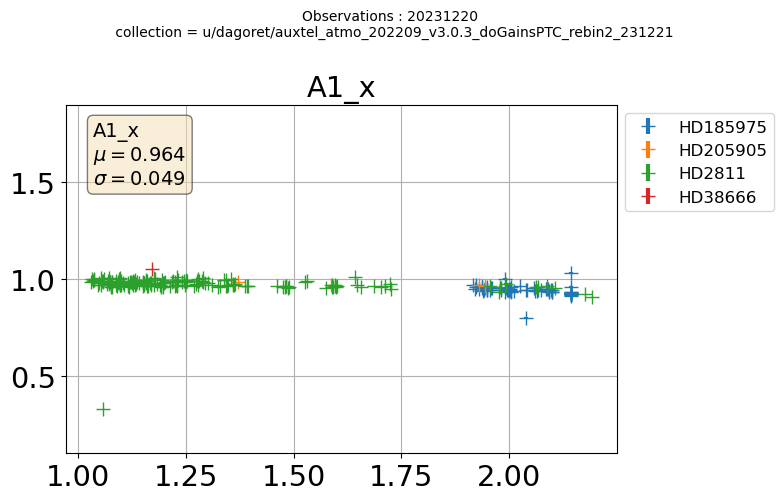

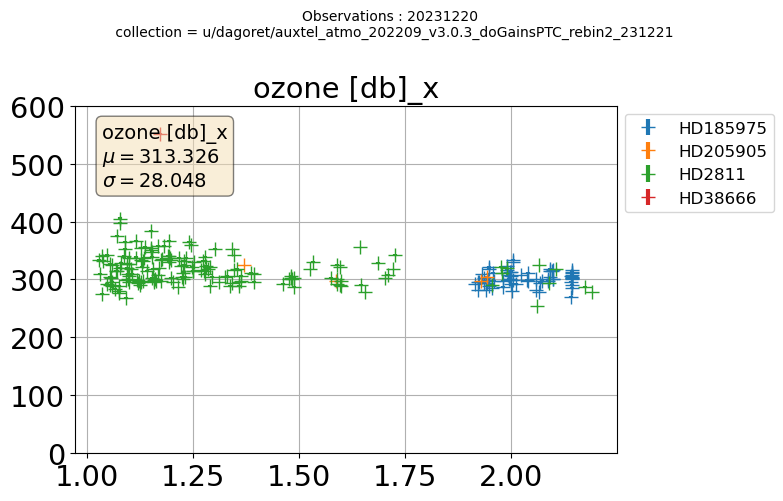

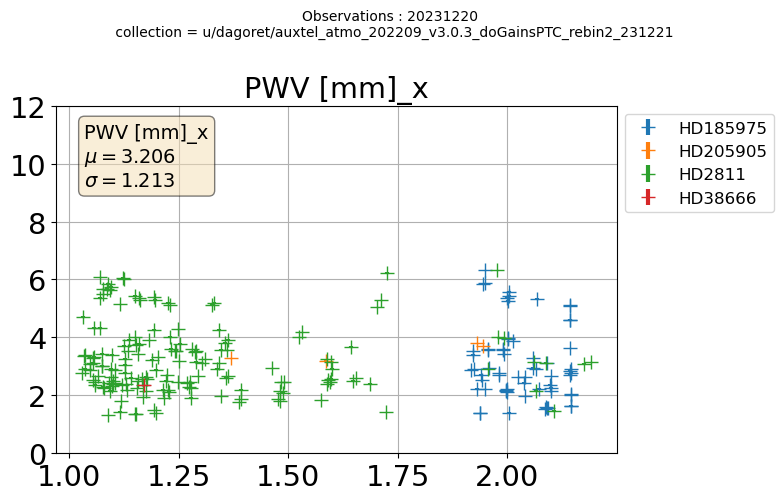

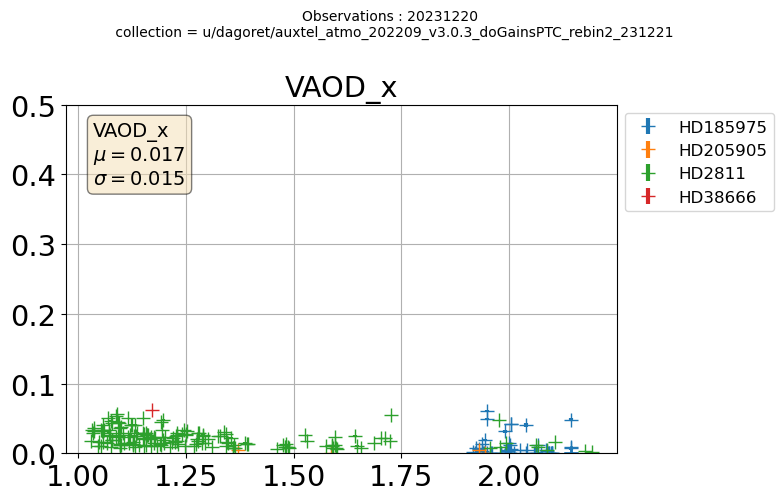

In [47]:
#for col in ["A1_x", "ozone [db]_x", "PWV [mm]_x", "VAOD_x", "D_CCD [mm]_x", "gamma_0_1", "gamma_0_2", "alpha_0_1", "alpha_0_2", "y_c_0_1", "y_c_0_2" ]:
for col in ["A1_x", "ozone [db]_x", "PWV [mm]_x", "VAOD_x"]:
    if len(col.split('_')) > 1:
        col_err = '_'.join(col.split('_')[:-1])+"_err_"+col.split('_')[-1]
    else:
        col_err = col+"_err"
    fig = plt.figure(figsize=(8,5))

    index = filtered  & (rec["FILTER"]=="empty")
    all_values = rec[col][index]
    
    mu = all_values.mean()
    sig =all_values.std()
    textstr = '\n'.join((col,
    r'$\mu=%.3f$' % (mu, ),
    r'$\sigma=%.3f$' % (sig, )))



    for star in stars:
        index = filtered & (rec["TARGET"] == star) & (rec["FILTER"]=="empty")
        if col_err in df.columns:
            plt.errorbar(rec["AIRMASS"][index], rec[col][index], yerr=rec[col_err][index], linestyle="none", marker="+",ms=10,lw=3 ,label=star)
        else:
            plt.plot(rec["AIRMASS"][index], rec[col][index], linestyle="none", marker="+",ms=10,lw=3 )
    plt.ylim((0.9*np.min(rec[col][filtered]), 1.1*np.max(rec[col][filtered])))
    if col in list(ATMMINMAX.keys()):
        plt.ylim(ATMMINMAX[col][0],ATMMINMAX[col][1])

    props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
    ax = plt.gca()
    # place a text box in upper left in axes coords
    ax.text(0.05, 0.95, textstr, transform=ax.transAxes, fontsize=14, verticalalignment='top', bbox=props)
    
    plt.grid()
    plt.title(col)
    plt.legend(bbox_to_anchor=(1,1), loc="upper left")
    #plt.gcf().autofmt_xdate()
    suptitle = f"Observations : {DATEOBS} \n collection = {my_collection}"
    plt.suptitle(suptitle,fontsize=10,y=1.0)
    plt.tight_layout()
    plt.show()


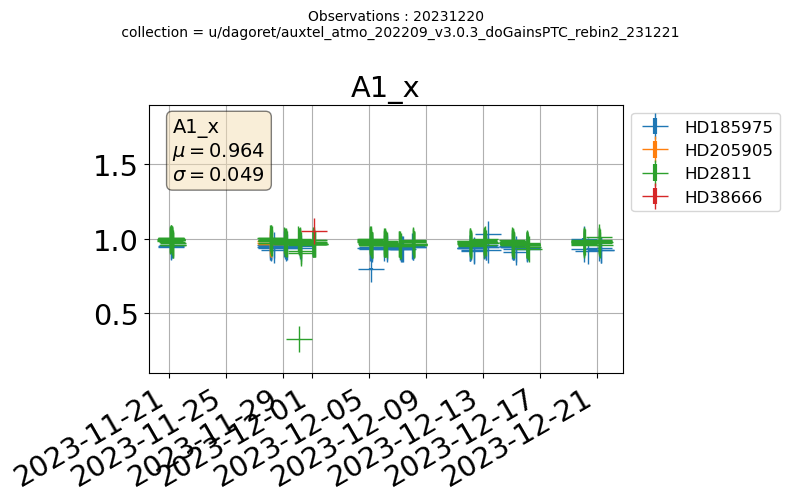

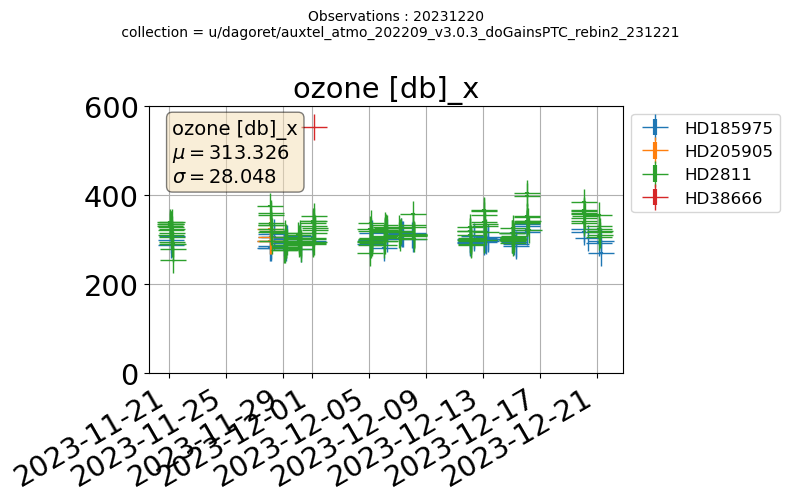

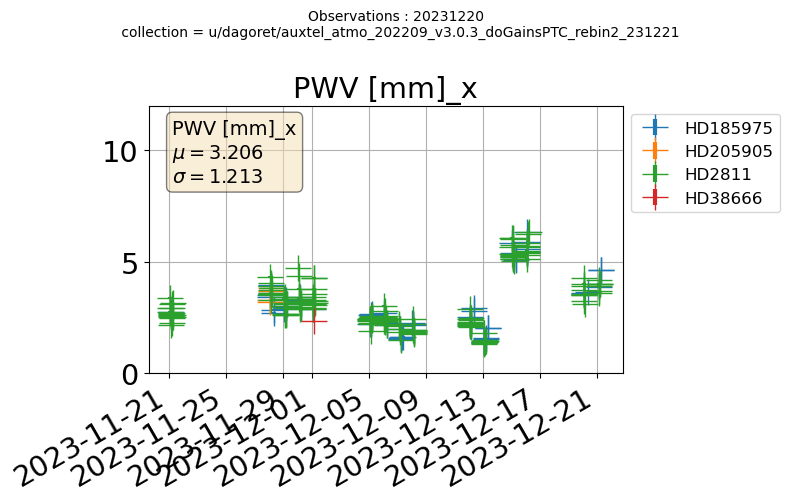

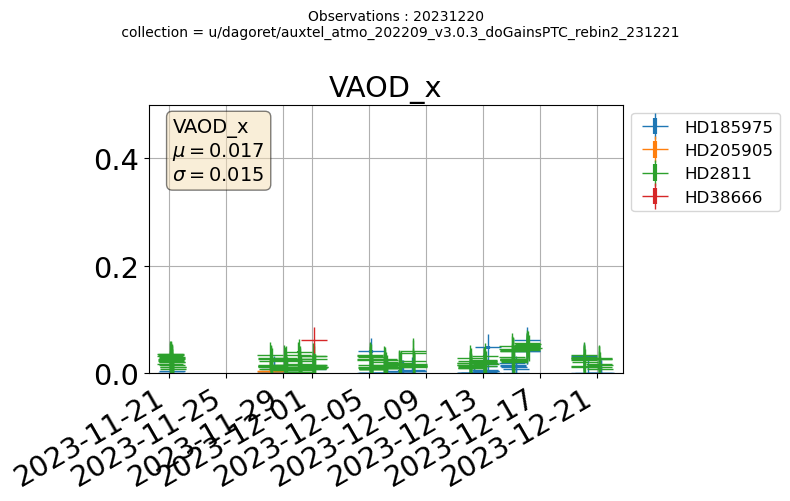

In [48]:
for col in ["A1_x", "ozone [db]_x", "PWV [mm]_x", "VAOD_x"]:
    if len(col.split('_')) > 1:
        col_err = '_'.join(col.split('_')[:-1])+"_err_"+col.split('_')[-1]
    else:
        col_err = col+"_err"

    index = filtered  & (rec["FILTER"]=="empty")
    all_values = rec[col][index]
    mu = all_values.mean()
    sig =all_values.std()
    textstr = '\n'.join((col,
    r'$\mu=%.3f$' % (mu, ),
    r'$\sigma=%.3f$' % (sig, )))

    fig = plt.figure(figsize=(8,5))
    for star in stars:
        index = filtered & (rec["TARGET"] == star)
        if col_err in df.columns:
            plt.errorbar(rec["DATE-OBS"][index], rec[col][index], yerr=rec[col_err][index], linestyle="none", marker="+",ms=19,lw=3 ,label=star)
        else:
            plt.plot(rec["DATE-OBS"][index], rec[col][index], linestyle="none", marker="+",ms=10,lw=3)
    plt.ylim((0.9*np.min(rec[col][filtered]), 1.1*np.max(rec[col][filtered])))
    if col in list(ATMMINMAX.keys()):
        plt.ylim(ATMMINMAX[col][0],ATMMINMAX[col][1])

    props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
    ax = plt.gca()
    # place a text box in upper left in axes coords
    ax.text(0.05, 0.95, textstr, transform=ax.transAxes, fontsize=14, verticalalignment='top', bbox=props)


    plt.grid()
    plt.title(col)
    plt.legend(bbox_to_anchor=(1,1), loc="upper left")
    plt.gcf().autofmt_xdate()
    suptitle = f"Observations : {DATEOBS} \n collection = {my_collection}"
    plt.suptitle(suptitle,fontsize=10,y=1.0)
    plt.tight_layout()
    plt.show()